<a href="https://colab.research.google.com/github/msquareddd/ai-engineering-notebooks/blob/main/DUDL/dudl_ffn_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COURSE: A deep understanding of deep learning


In [22]:
!pip -q install ucimlrepo

In [23]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for timing computations
import time

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [24]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

In [25]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


In [26]:
y = y.ne(0).astype(int)

In [27]:
X = X.fillna(0)

In [28]:
# X.info()

In [29]:
cols_to_score = X.keys()

In [30]:
cols_to_score = cols_to_score.drop(['sex','fbs','exang'])

In [31]:
X[cols_to_score] = X[cols_to_score].apply(stats.zscore)

In [32]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0.948726,1,-2.251775,0.757525,-0.264900,1,1.016684,0.017197,0,1.087338,2.274579,-0.711131,0.659133
1,1.392002,1,0.877985,1.611220,0.760415,0,1.016684,-1.821905,1,0.397182,0.649113,2.504881,-0.865426
2,1.392002,1,0.877985,-0.665300,-0.342283,0,1.016684,-0.902354,1,1.346147,0.649113,1.432877,1.167319
3,-1.932564,1,-0.165268,-0.096170,0.063974,0,-0.996749,1.637359,0,2.122573,2.274579,-0.711131,-0.865426
4,-1.489288,0,-1.208521,-0.096170,-0.825922,0,1.016684,0.980537,0,0.310912,-0.976352,-0.711131,-0.865426


# Re-organize the data: train/test in DataLoaders

In [33]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( X.values ).float()
labels = torch.tensor( y.values ).float()
# labels = labels[:,None] # transform to matrix

In [34]:
dataT.size()

torch.Size([303, 13])

In [35]:
labels.size()

torch.Size([303, 1])

In [36]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

batchsize  = 32
train_loader = DataLoader(train_dataDataset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# Now for the DL part

In [37]:
NUM_EPOCHS = 500
LR = 0.01
N_HIDDEN_1 = 128
N_HIDDEN_2 = 64
N_HIDDEN_3 = 32

In [38]:
# create a class for the model

class ANNhearth(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(13,N_HIDDEN_1)

    ### hidden layers
    self.fc1 = nn.Linear(N_HIDDEN_1,N_HIDDEN_2)
    self.fc2 = nn.Linear(N_HIDDEN_2,N_HIDDEN_3)
    self.fc3 = nn.Linear(N_HIDDEN_3,N_HIDDEN_3)

    ### output layer
    self.output = nn.Linear(N_HIDDEN_3,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) ) # fully connected
    x = F.relu( self.fc2(x) )
    x = F.relu( self.fc3(x) )
    return self.output(x)

# Train the model

In [39]:
# a function that trains the model

# global parameter
numepochs = NUM_EPOCHS

def trainTheModel():

  net = ANNhearth()

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(net.parameters(),lr=LR)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses,net

# Now for the experiment

In [40]:
trainAcc,testAcc,losses,net = trainTheModel()

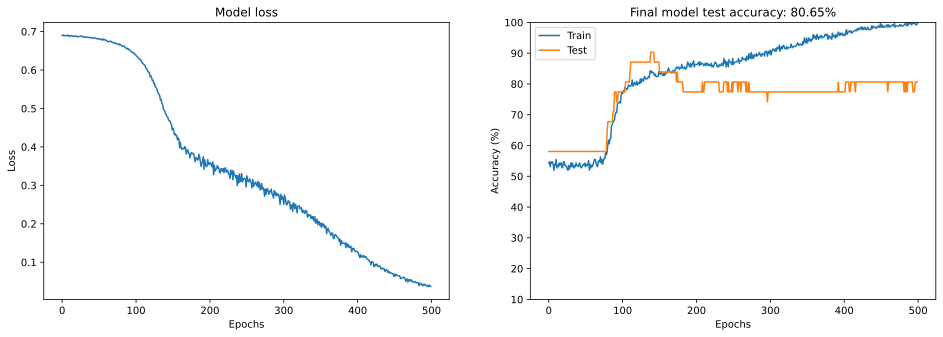

In [41]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
# ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()